### Testing Segmentation/Filtering
Has imports and cells for loading and psuedo-streaming SSVEP data

In [1]:
import sys
sys.path.append("..")
import time
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds, BrainFlowPresets
import numpy as np
from mvlearn.embed import CCA
import matplotlib.pyplot as plt

# Library Modules:
from modules.brainflow_stream import *
from modules.filtering import *
from modules.segmentation import *

# from modules.preprocessing import * # Old

pygame 2.6.0 (SDL 2.28.4, Python 3.8.19)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
data = np.load('simulated_test_SSVEP.npy')
data.shape

(8, 15000)

In [3]:
serial_port = 'COM4' 
board_id = BoardIds.SYNTHETIC_BOARD # BoardIds.PLAYBACK_FILE_BOARD -> only if recorded with a support board (I believe...)
frequencies = [9.25, 11.25, 13.25, 15.25] # Stimulus frequencies; used for CCA & harmonic generation
buttons = ['Right', 'Left', 'Up', 'Down'] # Adds custom text to each box - must be same length as frequencies 
button_pos = [0, 2, 3, 1] # Assigns positions to custom text - must be same length as buttons
segment_duration = 4 # seconds
display = 0 # Which screen to display the stimulus paradigm on --> 0 is default

# Static Variables - Probably don't need to touch :)
harmonics = np.arange(1, 4) # Generates the 1st, 2nd, & 3rd Harmonics
sampling_rate = BoardShim.get_sampling_rate(board_id)
n_samples = sampling_rate * segment_duration 


eeg_channels = BoardShim.get_eeg_names(board_id)
channel_names = ["O1", "O2", "Oz", "Pz", "P3", "P4", "POz", "P1"]
channel_mapping = dict(zip(eeg_channels, channel_names))

# Show board information
print(f"Sampling Rate: {sampling_rate}")
print(f"Default Channels: {eeg_channels}")
print(f"Channel Mapping: {channel_mapping}")

board = BrainFlowBoardSetup(board_id, serial_port)
# board.show_params() # Logger shows this info by default - this is another method to show
board.setup()

Sampling Rate: 250
Default Channels: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8', 'F5', 'F7', 'F3', 'F1', 'F2', 'F4', 'F6', 'F8']
Channel Mapping: {'Fz': 'O1', 'C3': 'O2', 'Cz': 'Oz', 'C4': 'Pz', 'Pz': 'P3', 'PO7': 'P4', 'Oz': 'POz', 'PO8': 'P1'}
Board setup and streaming started successfully


In [6]:
# board.stop()

for i in range(10):
    time.sleep(1)
    board.insert_marker(i+1)
    


Streaming stopped
Session released
Board is not streaming, cannot insert marker
Board is not streaming, cannot insert marker
Board is not streaming, cannot insert marker
Board is not streaming, cannot insert marker
Board is not streaming, cannot insert marker
Board is not streaming, cannot insert marker
Board is not streaming, cannot insert marker
Board is not streaming, cannot insert marker
Board is not streaming, cannot insert marker
Board is not streaming, cannot insert marker


### Testing Segmentation

In [4]:
# Example using the 'time_wait' method
segmentation_time_wait = Segmentation(board, segment_duration=2)
while True:
    segment = segmentation_time_wait.get_segment_time()
    if segment is not None:
        print("Time Wait Segment Retrieved:", segment.shape)

Time Wait Segment Retrieved: (32, 500)
Time Wait Segment Retrieved: (32, 500)
Time Wait Segment Retrieved: (32, 500)
Time Wait Segment Retrieved: (32, 500)
Time Wait Segment Retrieved: (32, 500)
Time Wait Segment Retrieved: (32, 500)
Time Wait Segment Retrieved: (32, 500)
Time Wait Segment Retrieved: (32, 500)


KeyboardInterrupt: 

In [5]:
# Example using the 'continuous' method
segmentation_continuous = Segmentation(board, segment_duration=2)
while True:
    segment = segmentation_continuous.get_segment()
    if segment is not None:
        print("Continuous Segment Retrieved:", segment.shape)
    time.sleep(2)

Continuous Segment Retrieved: (32, 500)
Continuous Segment Retrieved: (32, 500)
Continuous Segment Retrieved: (32, 500)
Continuous Segment Retrieved: (32, 500)
Continuous Segment Retrieved: (32, 500)
Continuous Segment Retrieved: (32, 500)


KeyboardInterrupt: 

### Testing Filtering

In [24]:
# Example sampling rate (in Hz)
sampling_rate = 250
# Initialize the Filtering class
filter_obj = Filtering(sampling_rate)

lowcut = 1.0  # Lower cutoff frequency in Hz
highcut = 50.0  # Upper cutoff frequency in Hz

eeg_data = segment[0:8, 0:100]
eeg_data.shape

(8, 100)

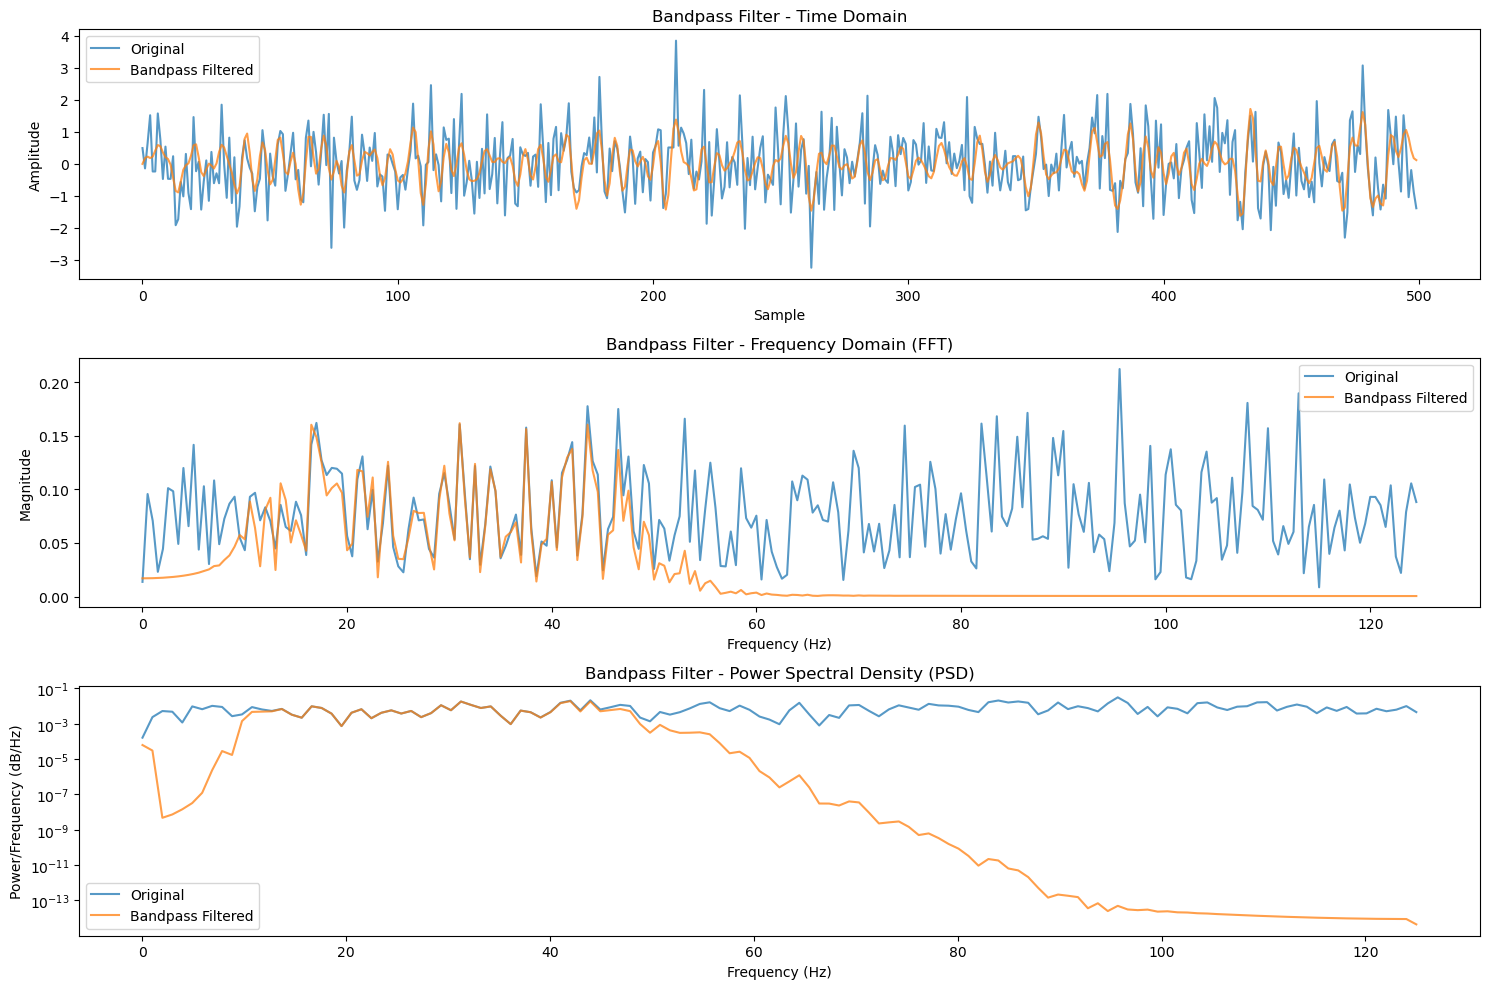

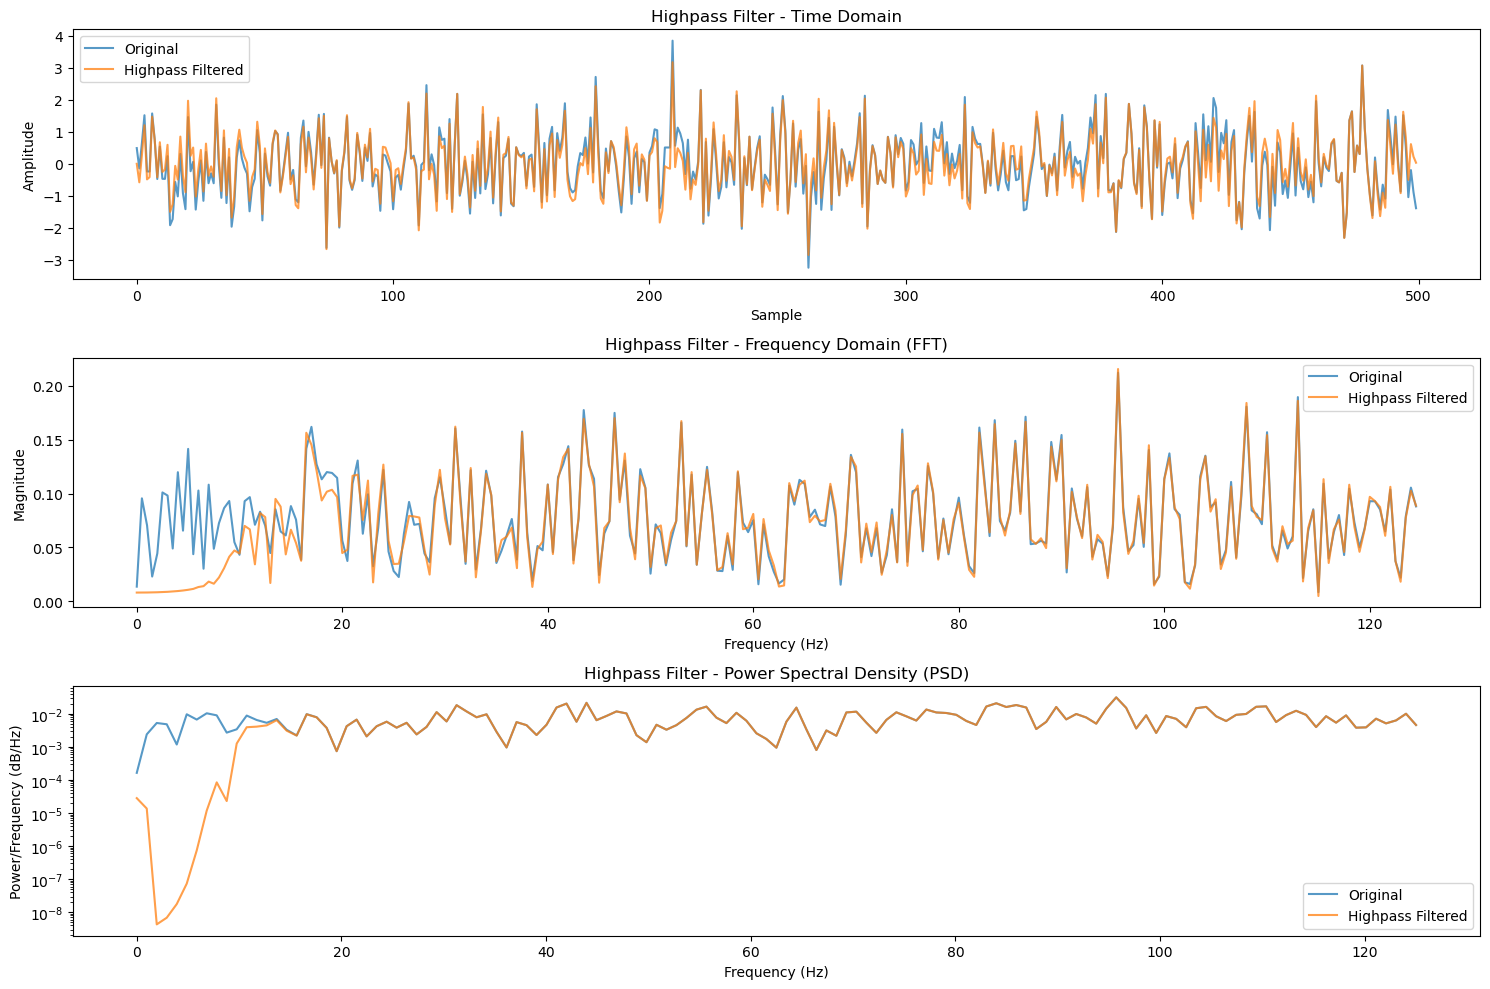

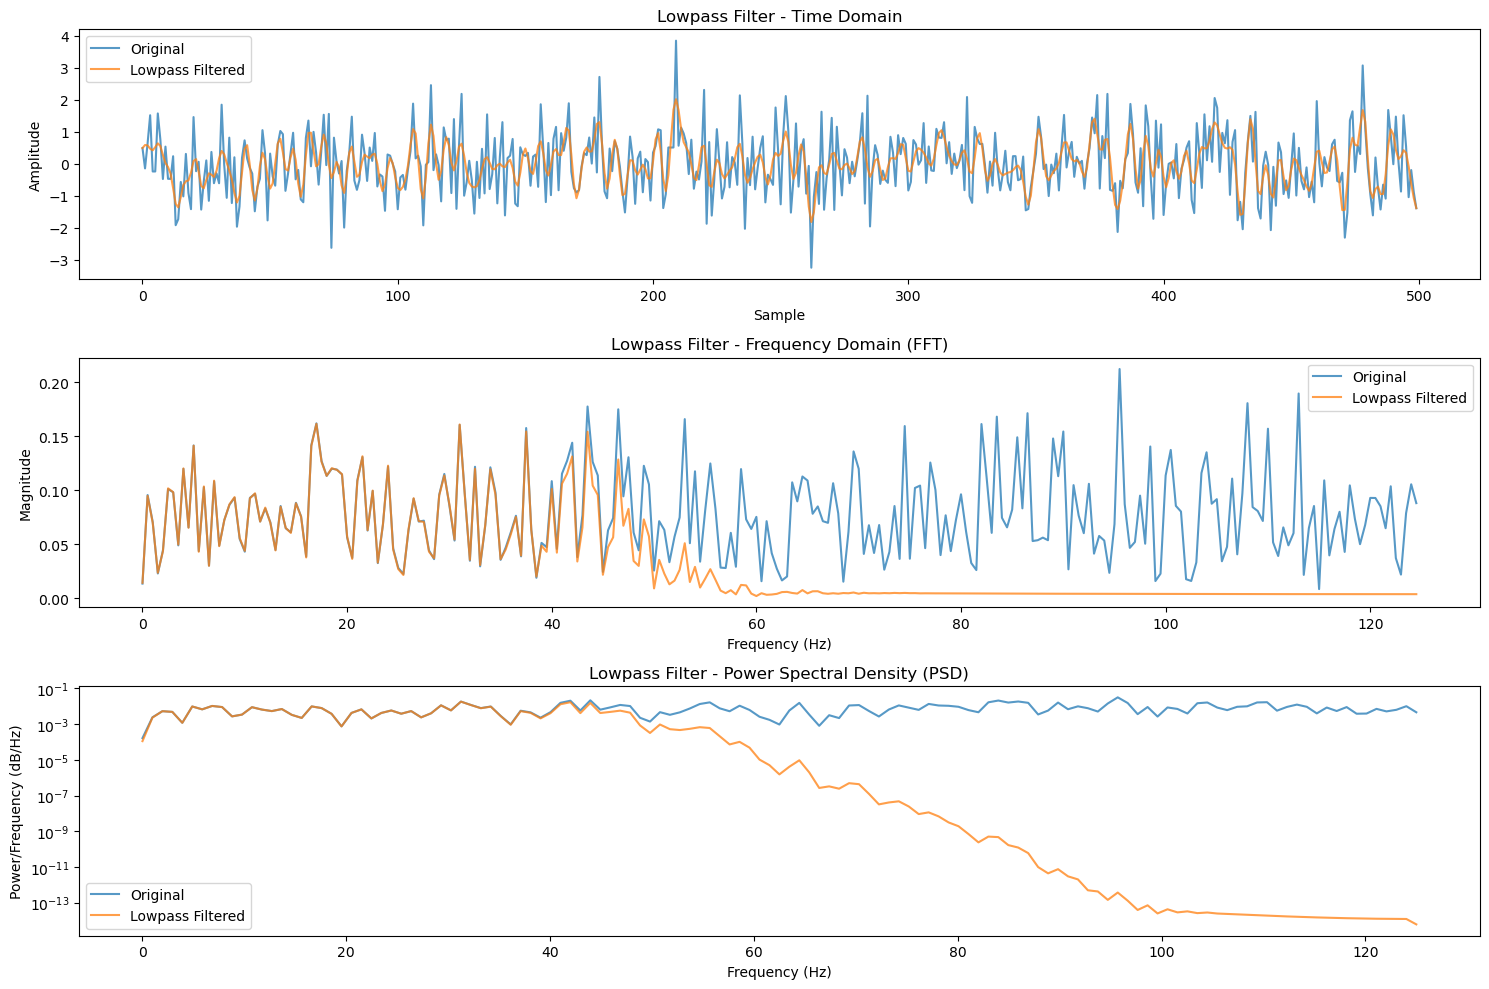

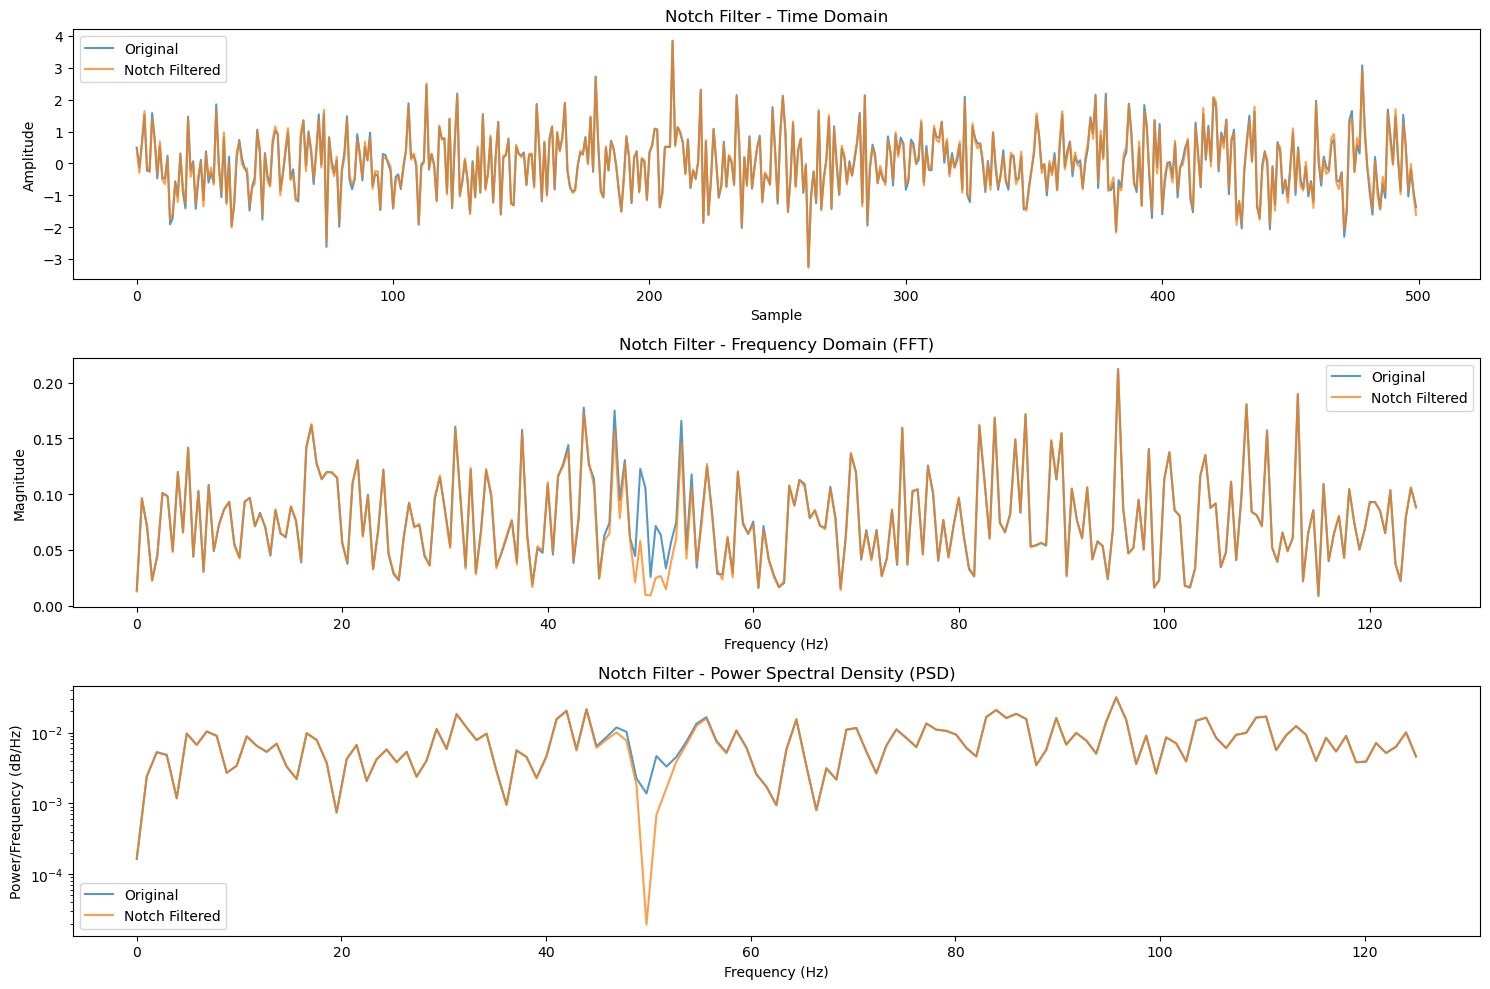

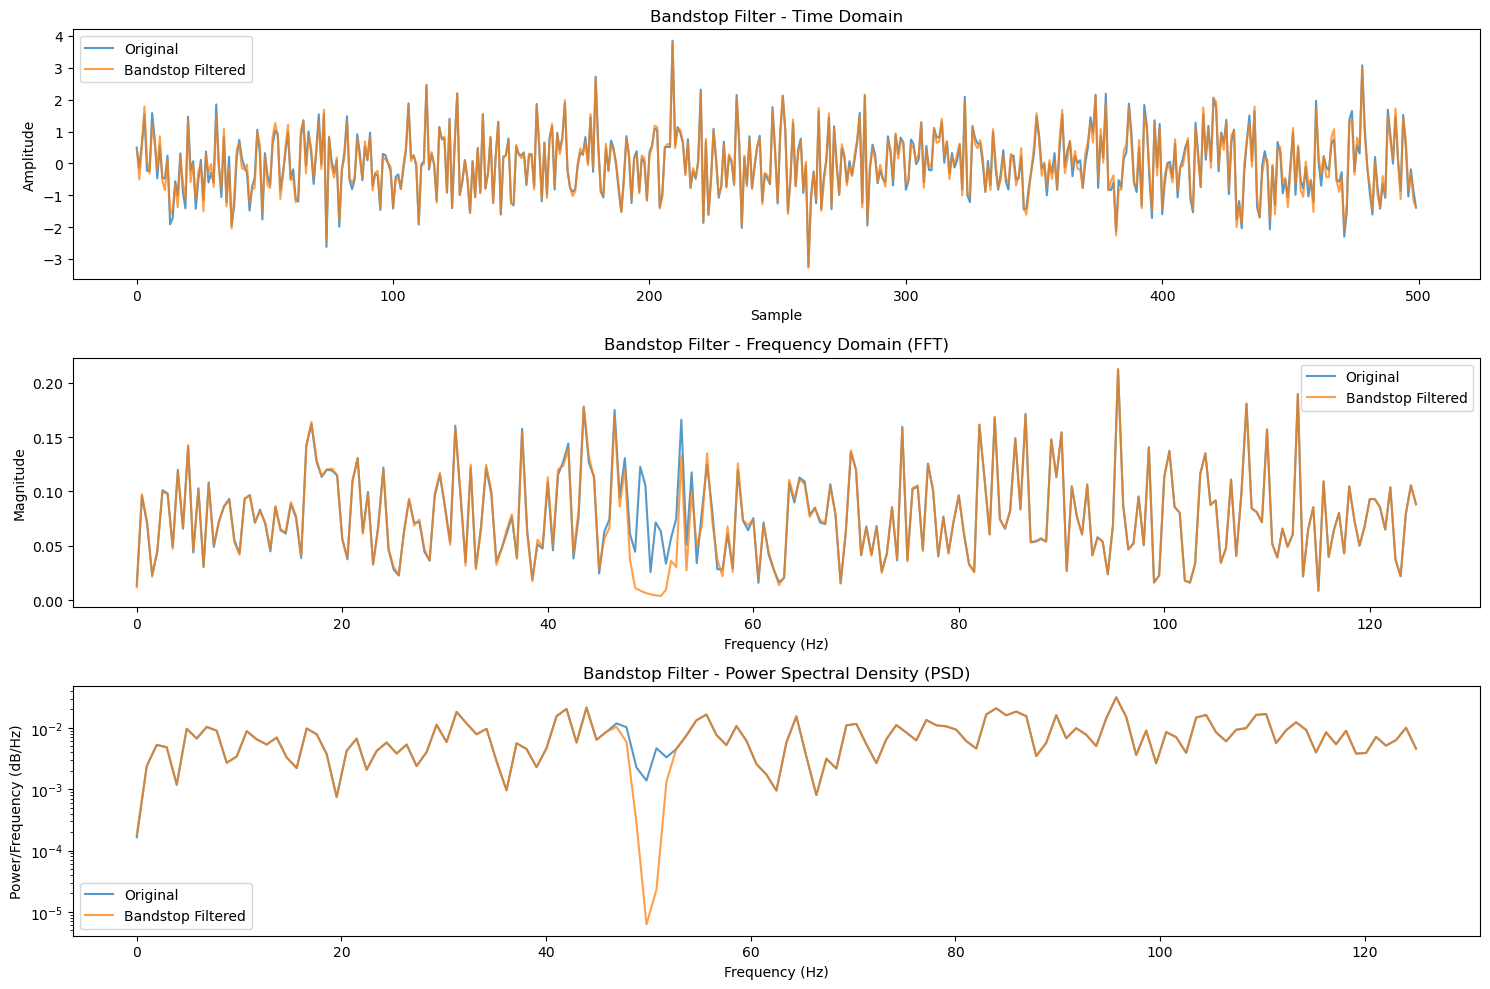

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import welch

# Assuming the Filtering class is already defined and imported
sampling_rate = 250  # Hz
filter_obj = Filtering(sampling_rate)

# Generate example EEG data (8 channels, 500 samples)
np.random.seed(42)
eeg_data = np.random.randn(8, 500)

# Define filter parameters for testing
filter_params = {
    "bandpass": {"lowcut": 10.0, "highcut": 50.0},
    "highpass": {"lowcut": 10.0},
    "lowpass": {"highcut": 50.0},
    "notch": {"notch_freq": 50.0},
    "bandstop": {"lowcut": 48.0, "highcut": 52.0}
}

# Choose a single channel to test
channel_idx = 0
original_signal = eeg_data[channel_idx]

# Function to plot time domain and frequency domain (FFT and PSD)
def plot_validation(original, filtered, filter_type):
    plt.figure(figsize=(15, 10))

    # Time domain plot
    plt.subplot(3, 1, 1)
    plt.plot(original, label='Original', alpha=0.75)
    plt.plot(filtered, label=f'{filter_type.capitalize()} Filtered', alpha=0.75)
    plt.title(f'{filter_type.capitalize()} Filter - Time Domain')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()

    # Frequency domain plot using FFT
    plt.subplot(3, 1, 2)
    N = len(original)
    T = 1.0 / sampling_rate
    yf_original = fft(original)
    yf_filtered = fft(filtered)
    xf = fftfreq(N, T)[:N//2]

    plt.plot(xf, 2.0/N * np.abs(yf_original[:N//2]), label='Original', alpha=0.75)
    plt.plot(xf, 2.0/N * np.abs(yf_filtered[:N//2]), label=f'{filter_type.capitalize()} Filtered', alpha=0.75)
    plt.title(f'{filter_type.capitalize()} Filter - Frequency Domain (FFT)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()

    # Power Spectral Density (PSD)
    plt.subplot(3, 1, 3)
    f_original, Pxx_original = welch(original, fs=sampling_rate, nperseg=256)
    f_filtered, Pxx_filtered = welch(filtered, fs=sampling_rate, nperseg=256)

    plt.semilogy(f_original, Pxx_original, label='Original', alpha=0.75)
    plt.semilogy(f_filtered, Pxx_filtered, label=f'{filter_type.capitalize()} Filtered', alpha=0.75)
    plt.title(f'{filter_type.capitalize()} Filter - Power Spectral Density (PSD)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Iterate through each filter type and validate
for filter_type, params in filter_params.items():
    # Apply the filter to the selected channel
    filtered_signal = filter_obj.filter_data(eeg_data[channel_idx:channel_idx+1], filter_type=filter_type, **params)[0]
    
    # Plot and validate
    plot_validation(original_signal, filtered_signal, filter_type)


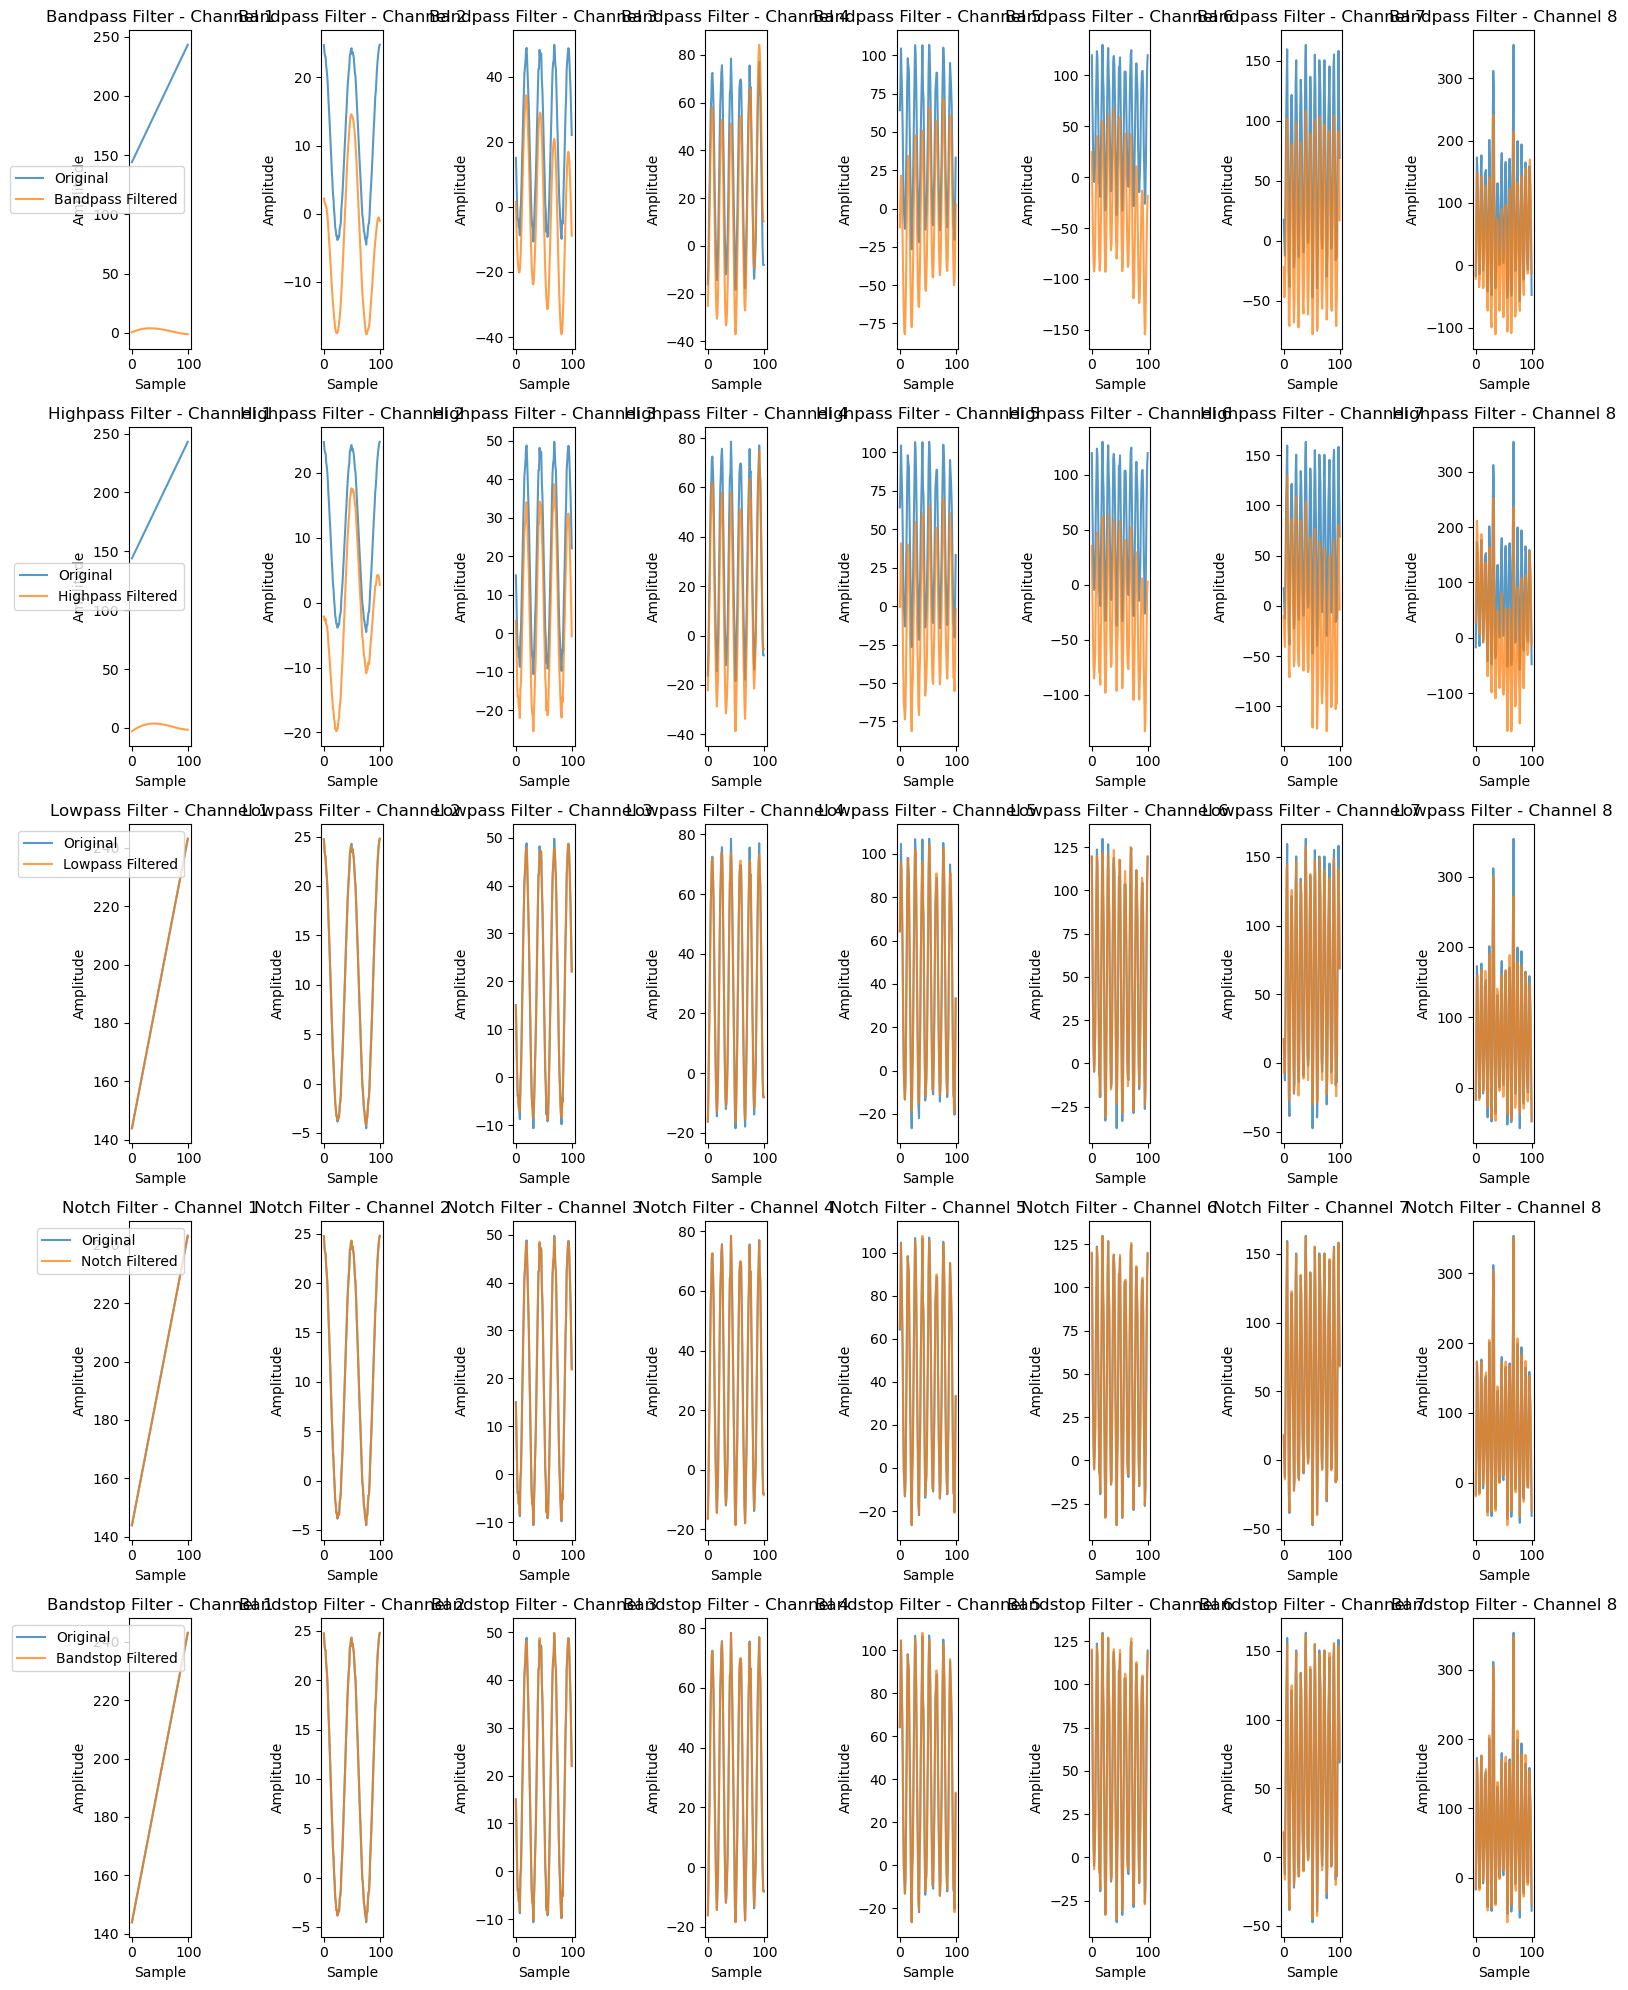

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, iirnotch, filtfilt

# Assuming the Filtering class is already defined as provided above

# Initialize the filtering object
sampling_rate = 250  # Example sampling rate in Hz
filter_obj = Filtering(sampling_rate)

# Generate example EEG data (8 channels, 500 samples)

# Define filter parameters
filter_params = {
    "bandpass": {"lowcut": 1.0, "highcut": 50.0},
    "highpass": {"lowcut": 1.0},
    "lowpass": {"highcut": 50.0},
    "notch": {"notch_freq": 50.0},
    "bandstop": {"lowcut": 48.0, "highcut": 52.0}
}

# Plot setup
num_channels = eeg_data.shape[0]
plt.figure(figsize=(15, 20))

# Iterate through each filter type and apply the filter
for i, filter_type in enumerate(filter_params.keys(), start=1):
    # Apply the filter to all channels of EEG data
    filtered_data = filter_obj.filter_data(eeg_data, filter_type=filter_type, **filter_params[filter_type])
    
    # Plot original data and filtered data for each channel
    for ch in range(num_channels):
        plt.subplot(len(filter_params), num_channels, (i - 1) * num_channels + ch + 1)
        plt.plot(eeg_data[ch], label='Original', alpha=0.75)
        plt.plot(filtered_data[ch], label=f'{filter_type.capitalize()} Filtered', alpha=0.75)
        plt.title(f'{filter_type.capitalize()} Filter - Channel {ch + 1}')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        if ch == 0:
            plt.legend()

plt.tight_layout()
plt.show()


#### Old Code/Reference:

In [6]:
board.stop()

Sampling Rate: 250
Default Channels: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8', 'F5', 'F7', 'F3', 'F1', 'F2', 'F4', 'F6', 'F8']
Channel Mapping: {'Fz': 'O1', 'C3': 'O2', 'Cz': 'Oz', 'C4': 'Pz', 'Pz': 'P3', 'PO7': 'P4', 'Oz': 'POz', 'PO8': 'P1'}
Board setup and streaming started successfully


In [7]:
segmenter = PreProcess(board, segment_duration=segment_duration)
classifier = ClassifySSVEP(frequencies, harmonics, sampling_rate, n_samples, stack_harmonics=False)
classifier_stacked = ClassifySSVEP(frequencies, harmonics, sampling_rate, n_samples, stack_harmonics=True)

while True:
    segment = segmenter.get_segment()
    if segment is not None:
        
        # print(f"Segment shape: {segment.shape}")
        eeg_segment = segment[0:8, :]

        # Step 2: Filter the data
        filtered_segment = segmenter.filter_data(eeg_segment)
        print("Filtered data shape:", filtered_segment.shape)

        # Step 3: Use CCA to match the EEG & Reference (harmonic) signals
            # Unstacked Harmonics (testing)
        detected_freq, correlation = classifier.cca_analysis(filtered_segment)
            # Stacked Harmonics (testing)
        detected_freq_stacked, correlation_stacked = classifier_stacked.cca_analysis(filtered_segment)
        
        print(f"Detected frequency: {detected_freq} Hz with correlation: {correlation}")

        # Optionally save or process the data further
        # segmenter.save_data(filtered_data, "filtered_data.csv")
        # segmenter.save_data(features, "features.csv")

    # Sleep for a while to collect new data
    time.sleep(segmenter.segment_duration)

NameError: name 'PreProcess' is not defined